### Source code

In [24]:
import numpy as np
from calendar import isleap
from scipy.stats import norm


class SolarGenerator(object):
    def __init__(self, init_date, delta_t, np_random, p_max=1.):
        self.np_random = np_random
        self.p_max = p_max
        self.delta_t = delta_t
        self.date = init_date

        self.bell_noise_factor = 0.05
        self.scale = 0.005
        self.prev_p = 0.
        self.h = (self.date.hour + self.date.minute / 60.) % 24.
        self.prev_base = None
        self.prev_day = None

    def __iter__(self):
        return self

    def __next__(self):
        
        if self.prev_base is None:
            self._next_base()

        diff = self.prev_base - self.prev_p
        noise = self.np_random.normal(loc=diff, scale=self.scale)
        self.prev_p += noise

        # Clip production to 0 before sunrise and after sunset.
        if self.date.hour < self.sunrise or self.date.hour > self.sunset:
            self.prev_p = 0.

        # Make sure that P stays within [0, 1].
        self.prev_p = np.maximum(self.prev_p, 0.)
        self.prev_p = np.minimum(self.prev_p, 1.)

        # Compute the next base value.
        self._next_base()

        # Increment the date.
        self.date += self.delta_t

        return self.prev_p * self.p_max

    def next(self):
        return self.__next__()

    def _next_base(self):
        self._sunset_sunrise_pattern()
        self.prev_base = self._bell_curve() * self._yearly_pattern()

    def _sunset_sunrise_pattern(self):
        """
        Compute the sunset and sunrise hour, based on the date of the year.
        """
        # Shift hour to be centered on December, 22nd (Winter Solstice).
        since_1st_jan = (self.date - dt.datetime(self.date.year, 1, 1))
        delta_hour = since_1st_jan.days * 24 + since_1st_jan.seconds // 3600
        
        h = delta_hour + 240
        T = 24 * (365 + isleap(self.date.year))

        self.sunset = 1.5 * np.sin(h * 2 * np.pi / T) + 18.5
        self.sunrise = 1.5 * np.sin(h * 2 * np.pi / T) + 5.5

    def _bell_curve(self):
        """
        Return the a noisy solar generation-like (bell) curve value at hour t.

        This function returns a capacity factor for solar generation following a
        bell curve (Gaussian), given a time of the day. It is assumed that hour=0
        represents 12:00 a.m., i.e. hour=26 => 2:00 a.m. Noise is also added
        sampled from a Gaussian N(0, 1).

        :return: the noisy solar generation, normalized in [0, 1].
        """

        h = (self.date.hour + self.date.minute / 60.) % 24.
        y = lambda x: norm.pdf(x, loc=12., scale=2.)
        if self.sunrise < h < self.sunset:
            p = y(h) / y(12.)
            # Add noise to the capacity factor (stochastic).
            p += self.bell_noise_factor * self.np_random.normal(loc=0., scale=1.)
        else:
            p = 0.

        return p

    def _yearly_pattern(self):
        """
        Return a factor to scale solar generation, based on the time of the year.

        This function returns a factor in [0.5, 1.0] used to scale the solar
        power generation curves, based on the time of the year, following a
        simple sinusoid. The base hour=0 represents 12:00 a.m. on January,
        1st. The sinusoid is designed to return its minimum value on the
        Winter Solstice and its maximum value on the Summer one.

        :return: a solar generation scaling factor in [0, 1].
        """

        # Shift hour to be centered on December, 22nd (Winter Solstice).
        since_1st_jan = (self.date - dt.datetime(self.date.year, 1, 1))
        delta_hour = since_1st_jan.days * 24 + since_1st_jan.seconds // 3600
        
        h = delta_hour + 240
        T = 24 * (365 + isleap(self.date.year))

        r =  0.25 * np.sin(h * 2 * np.pi / T - np.pi / 2) + 0.75
        return r

In [25]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [26]:
P_max = [10, 20]
solars = []
init_date = dt.datetime(2019, 1, 1)
delta_t = dt.timedelta(minutes=15)
np_random = np.random.RandomState(2019)

for p_max in P_max:
    new_solar = SolarGenerator(init_date, delta_t, np_random, p_max)
    solars.append(new_solar)

### Display curves generated by solar panels over the same period

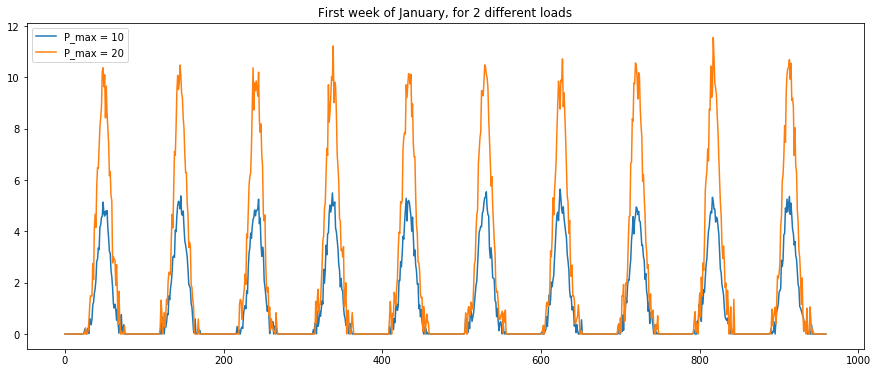

In [27]:
plt.figure(figsize=(15, 6))
for i, solar in enumerate(solars):
    series = []
    for _ in range(4*24*10):
        series.append(next(solar))
    plt.plot(series, label=f'P_max = {P_max[i]}')
plt.title('First week of January, for 2 different loads')
plt.legend()

### Display curves generated at different times of the year.

In [28]:
p_max = 10
solar_months = []
for month in [1, 4, 7, 10]:
    init_date = dt.datetime(2019, month, 1)
    new_solar = SolarGenerator(init_date, delta_t, np_random, p_max)
    solar_months.append(new_solar)

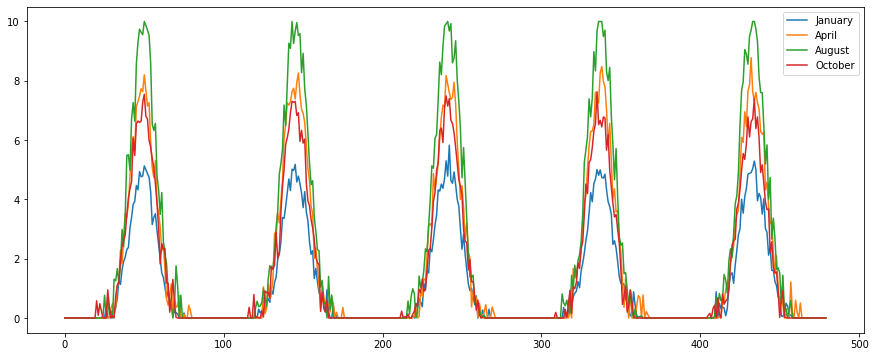

In [29]:
plt.figure(figsize=(15, 6))
months = ['January', 'April', 'August', 'October']
for i, solar in enumerate(solar_months):
    series = []
    for _ in range(4*24*5):
        series.append(next(solar))
    plt.plot(series, label=months[i])
plt.title('')
plt.legend()

### Display sunset and sunrise curves

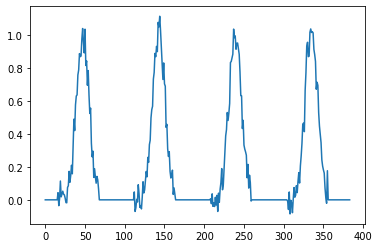

In [33]:
solar = SolarGenerator(init_date, delta_t, np_random, p_max)
sunset, sunrise, bell_curve = [], [], []
for i in range(24*4*4):
    next(solar)
    sunset.append(solar.sunset)
    sunrise.append(solar.sunrise)
    bell_curve.append(solar._bell_curve())
    
# plt.plot(sunset)
# plt.plot(sunrise)
plt.plot(bell_curve)